**Dataset: ICCAD-2012**

You can download the ICCAD-2012 dataset as a ZIP file from the following link: [ICCAD-2012](https://drive.google.com/file/d/1lawhHhiJklrrgr2SlO172n1X69XRnsM1/view?usp=share_link) Download.

Please note that the file is large (approximately 136 MB), so there is no need to extract it after downloading. Simply download the ZIP file and upload it directly to your Google Drive in the location where you intend to access it later.

**Example:**
In my Google Drive, I have a folder named Coin-3D, which contains another folder called Lithograph. I uploaded the ZIP file directly into the Lithograph folder.



How the ICCAD Dataset looks like?
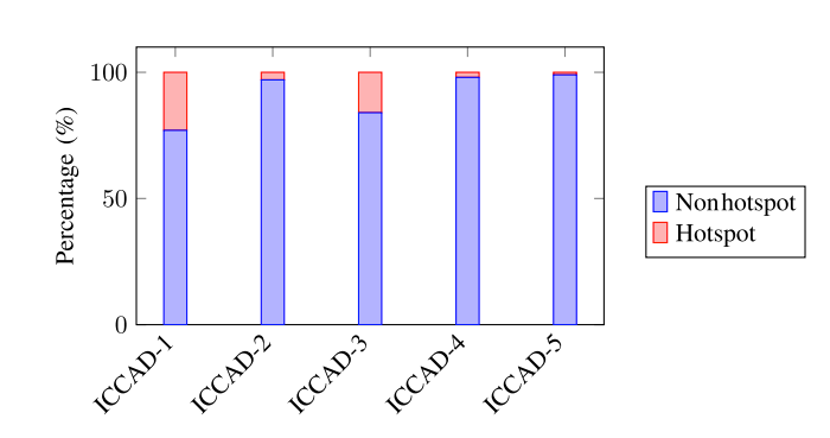



**Google Drive Access**

To access files stored in your Google Drive from this notebook, you first need to mount your Google Drive. This connects your Drive to the Colab environment so you can read or write files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Extracts a .rar file from  Google Drive**

This command extracts a .rar file from your Google Drive into the Colab working directory.
!unrar x tells Colab to use the unrar tool to extract the file.
The path after it is the location of the .rar file in your Drive, and -d /content/ sets the destination folder for the extracted contents.

In [ ]:
!unrar x /content/drive/MyDrive/Coin-3D/Lithography/iccad_official.rar -d /content/


Streaming output truncated to the last 5000 lines.
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png3.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png4.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png6.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png7.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png8.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5743.png9.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png1.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png2.png      97%  OK 
Extracting  /content/iccad-official/iccad5/test/test_nhs/NNHSCAD5744.png3.png      97%  OK 
Extracting  /content/iccad-official/icca

**Important Libraries**

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models


**Step. 3: Create a Custom Dataset Class
Modify the root and class folder names as needed:**  

In [ ]:
class LayoutDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for label, class_name in enumerate(["non_hotspot", "hotspot"]):  # adjust folder names
            class_dir = os.path.join(root_dir, class_name)
            for file in os.listdir(class_dir):
                if file.endswith(".png") or file.endswith(".jpg"):
                    self.samples.append((os.path.join(class_dir, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


**Step 4: Define Transforms and Load Data**

In [ ]:
class MultiICCADLayoutDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.transform = transform
        self.samples = []

        # ICCAD1 to ICCAD5
        for i in range(1, 6):
            iccad_path = os.path.join(base_dir, f"iccad{i}", "train")
            class_map = {
                "train_nhs": 0,  # non-hotspot
                "train_hs": 1    # hotspot
            }
            for class_name, label in class_map.items():
                class_dir = os.path.join(iccad_path, class_name)
                if not os.path.exists(class_dir): continue
                for file in os.listdir(class_dir):
                    if file.lower().endswith((".png", ".jpg", ".jpeg")):
                        self.samples.append((os.path.join(class_dir, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


**Step 4: Preprocess and Load Data**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = MultiICCADLayoutDataset("/content/iccad-official", transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



**Step 5: Define Modified VGG13 Model**

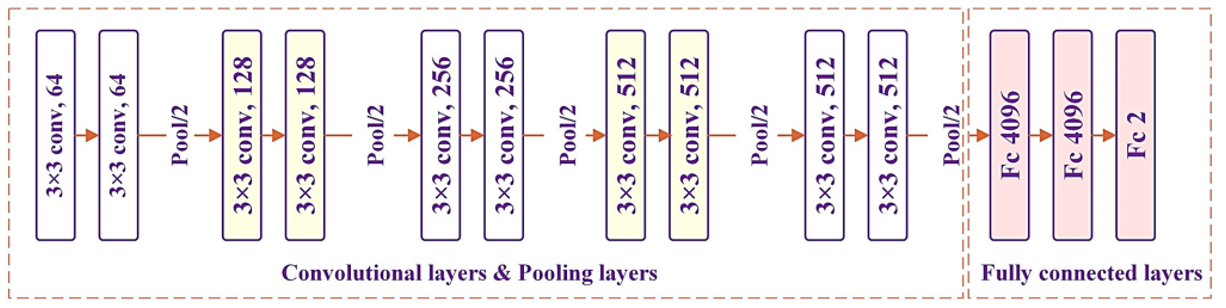

In [ ]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained VGG13 model
model = models.vgg13(pretrained=True)

# Freeze the convolutional (feature extraction) layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier with a custom one for binary classification
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2)  # Output 2 classes
)

# Move model to the selected device
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Step 6: Train the Model**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

for epoch in range(15):  # Feel free to increase
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Track predictions for accuracy
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute accuracy for this epoch
    epoch_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {epoch_acc:.4f}")


100%|██████████| 469/469 [04:40<00:00,  1.67it/s]


Epoch 1, Loss: 44.1006, Accuracy: 0.9658


100%|██████████| 469/469 [04:39<00:00,  1.68it/s]


Epoch 2, Loss: 19.2508, Accuracy: 0.9841


100%|██████████| 469/469 [04:40<00:00,  1.67it/s]


Epoch 3, Loss: 13.1368, Accuracy: 0.9897


100%|██████████| 469/469 [04:39<00:00,  1.68it/s]


Epoch 4, Loss: 9.2220, Accuracy: 0.9927


100%|██████████| 469/469 [04:37<00:00,  1.69it/s]


Epoch 5, Loss: 5.3771, Accuracy: 0.9964


100%|██████████| 469/469 [04:37<00:00,  1.69it/s]


Epoch 6, Loss: 3.7368, Accuracy: 0.9970


100%|██████████| 469/469 [04:37<00:00,  1.69it/s]


Epoch 7, Loss: 3.3070, Accuracy: 0.9969


100%|██████████| 469/469 [04:38<00:00,  1.68it/s]


Epoch 8, Loss: 4.3818, Accuracy: 0.9966


100%|██████████| 469/469 [04:38<00:00,  1.68it/s]


Epoch 9, Loss: 4.0582, Accuracy: 0.9969


100%|██████████| 469/469 [04:38<00:00,  1.68it/s]


Epoch 10, Loss: 1.3815, Accuracy: 0.9994


100%|██████████| 469/469 [04:37<00:00,  1.69it/s]


Epoch 11, Loss: 2.5805, Accuracy: 0.9981


100%|██████████| 469/469 [04:38<00:00,  1.68it/s]


Epoch 12, Loss: 2.7565, Accuracy: 0.9977


100%|██████████| 469/469 [04:38<00:00,  1.68it/s]


Epoch 13, Loss: 2.3004, Accuracy: 0.9985


100%|██████████| 469/469 [04:37<00:00,  1.69it/s]


Epoch 14, Loss: 2.6548, Accuracy: 0.9981


100%|██████████| 469/469 [04:38<00:00,  1.68it/s]

Epoch 15, Loss: 2.9164, Accuracy: 0.9977


 **Step 7: Evaluate Performance**

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9896
Precision: 0.9447
Recall: 0.9053
F1 Score: 0.9246


**References **


1.   Imbalance aware lithography hotspot detection: a deep learning approach
2.  Lithography Hotspot Detection Method Based on Transfer Learning Using Pre-Trained Deep Convolutional Neural Network
